# Preliminaries

The program was run using Google Colab with GPU, Tesla T4. For finetuning the pretrained models to the desired datasets, the Hugging Face Trainer API was used. Datasets include a local fake news dataset (Filipino) and the Kaggle fake news dataset from UTK Machine Learning Club 2017.

This experiment will mainly cover creating an adversarial attack by removing adverbs.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install datasets
!pip install transformers
!pip uninstall -y transformers accelerate
!pip install transformers accelerate
!pip install captum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Found existing installation: transformers 4.30.2
Uninstalling transformers-4.30.2:
  Successfully uninstalled transformers-4.30.2
Found existing installation: accelerate 0.20.3
Uninstalling accelerate-0.20.3:
  Successfully uninstalled accelerate-0.20.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached transformers-4.30.2-py3-none-any.whl (7.2 MB)
  Using cached accelerate-0.20.3-py3-none-any.whl (227 kB)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import string
import re
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import EarlyStoppingCallback
import plotly.express as px
from captum.attr import LayerIntegratedGradients, visualization as viz
from scipy.special import softmax

In [ ]:
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

Load the cleaned test datasets to be used by BERT and BERT-Tagalog

In [ ]:
!cp "/content/drive/Shared drives/Thesis/Datasets/Kaggle-Fake-News/CleanFinal/test-eng-clean-remove-e.csv" "test-eng.csv"
!cp "/content/drive/Shared drives/Thesis/Datasets/Fake-News-Filipino/test-fil-clean.csv" "test-fil.csv"

# Kaggle Fake News Dataset

Use the train.csv file from [Kaggle Fake News Dataset](https://www.kaggle.com/competitions/fake-news/data) containing over 20000 news articles labeled as 0 when reliable, and 1 when unreliable. We split the training dataset to 70-30 wherein the new training dataset forms 70% while the test dataset forms the 30%.

In [ ]:
df_test = pd.read_csv('test-eng.csv')

## Preprocessing

*remove_words* is a list that contains adverbs to be removed.

In [ ]:
remove_words = ['absolutely', 'amazingly', 'awfully', 'barely',
                'completely', 'considerably', 'decidedly', 'deeply',
                'enormously', 'entirely', 'especially', 'exceptionally',
                'exclusively', 'extremely', 'fully', 'greatly', 'hardly',
                "hella", 'highly', 'hugely', 'incredibly', 'intensely',
                'majorly', 'overwhelmingly', 'really', 'remarkably',
                'substantially', 'thoroughly', 'totally', 'tremendously',
                'unbelievably', 'unusually', 'utterly', 'very']

`df_test['adverbs']` contains the adverbs stripped from each article.

In [ ]:
pat = '|'.join([r'(?<![a-zA-Z0-9])(?i:{})(?![a-zA-Z0-9])'.format(w) for w in remove_words])

df_test['adverbs'] = df_test['text'].str.findall(pat).apply(', '.join)

In [ ]:
df_test['adverbs'].head()

0                                                     
1                                                     
2    especially, totally, entirely, very, very, hug...
3                                   really, especially
4                                           absolutely
Name: adverbs, dtype: object

We remove this adverbs and create a new column called `df_test['text_new]` which now contains the modified articles.

In [ ]:
pat = '|'.join([r'(?<![a-zA-Z0-9])(?i:{})(?![a-zA-Z0-9])'.format(w) for w in remove_words])
df_test['text_new'] = df_test['text'].str.replace(pat, ' ')

<ipython-input-95-3b53e8a25640>:2: FutureWarning:

The default value of regex will change from True to False in a future version.



Since the above code converts *was very,* to *was ,* we remove the excess whitespace. This now becomes *was,*.

In [ ]:
df_test['text_new'] = df_test['text_new'].str.replace('  ', '')

We create a new dataframe called `df_test_adv` that consists of three columns namely: `text`, `label`, and `adverbs`.

In [ ]:
df_test_orig = df_test[['text','label']]
df_test_adv  = df_test[['text_new','label','adverbs']].rename(columns={'text_new':'text'})

`df_test_adv` is converted to a csv file and this will be used as the adversarial dataset for evaluation.

In [ ]:
df_test_adv.to_csv('/content/drive/Shared drives/Thesis/Datasets/Kaggle-Fake-News/Adv/DA-test-eng-adv.csv', index=False)

## Evaluation

Load existing adversarial dataset

In [ ]:
!cp "/content/drive/Shared drives/Thesis/Datasets/Kaggle-Fake-News/Adv/DA-test-eng-adv.csv" "test-eng-adv.csv"

Load the finetuned model

In [ ]:
# Load the finetuned model
pretrained = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(pretrained)
model = AutoModelForSequenceClassification.from_pretrained(pretrained)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [ ]:
!cp -r "/content/drive/Shared drives/Thesis/Models/uncased-output-eng" "output-eng"

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

Define a new dataset `analysis_data` which will be used to analyze the results.

In [ ]:
analysis_data = pd.read_csv('test-eng-adv.csv')

### Model Performance (Original)

Generate predictions using model *output-eng/checkpoint-3000* for the original dataset.

In [ ]:
test_data = pd.read_csv("test-eng.csv")
test_data = test_data[test_data['text'].notnull()]

X_test = list(test_data["text"])
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)
y_test = list(test_data["label"])

test_dataset = Dataset(X_test_tokenized)

model_path = "output-eng/checkpoint-3500"
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=2)

test_trainer = Trainer(model)

raw_pred, _, _ = test_trainer.predict(test_dataset)
y_pred_orig = np.argmax(raw_pred, axis=1)

In [ ]:
original_predictions = test_trainer.predict(test_dataset).predictions

In [ ]:
accuracy = accuracy_score(y_test, y_pred_orig)
recall = recall_score(y_test, y_pred_orig)
precision = precision_score(y_test, y_pred_orig)
f1 = f1_score(y_test, y_pred_orig)

print("ADVERSARIAL TEST DATASET (ENGLISH):")
print("Accuracy: {}".format(accuracy))
print("Recall: {}".format(recall))
print("Precision: {}".format(precision))
print("F1-score: {}".format(f1))

cm = confusion_matrix(y_test, y_pred_orig)

fig = px.imshow(cm, text_auto=True, title='Confusion Matrix of original test data (English Fake News)', color_continuous_scale='haline')
fig.update_xaxes(dtick=1)
fig.update_yaxes(dtick=1)
fig.show()

ADVERSARIAL TEST DATASET (ENGLISH):
Accuracy: 0.9964151587572551
Recall: 0.99624445203141
Precision: 0.9965846994535519
F1-score: 0.9964145466962608


In [ ]:
analysis_data['unprocessed'] = list(test_data["text"])
analysis_data['orig_pred'] = y_pred_orig

Generate predictions using model *output-eng/checkpoint-3000* for the adversarial dataset.

In [ ]:
test_data = pd.read_csv("test-eng-adv.csv")
test_data = test_data[test_data['text'].notnull()]

X_test = list(test_data["text"])
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)
y_test = list(test_data["label"])

test_dataset = Dataset(X_test_tokenized)

model_path = "output-eng/checkpoint-3500"
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=2)

test_trainer = Trainer(model)

raw_pred, _, _ = test_trainer.predict(test_dataset)
y_pred = np.argmax(raw_pred, axis=1)

In [ ]:
adversarial_predictions = test_trainer.predict(test_dataset).predictions

In [ ]:
analysis_data['adv_pred'] = y_pred

In [ ]:
analysis_data['processed'] = list(test_data["text"])

### Average Probability Change

In [ ]:
original_probs = softmax(original_predictions, axis=1)
adversarial_probs = softmax(adversarial_predictions, axis=1)
delta_lst = adversarial_probs[:, 1] - original_probs[:, 1]
average_prob_change = round(float(np.mean(delta_lst)), 4)

print(f"Average Probability Change: {average_prob_change}")

Average Probability Change: 0.0001


### %LabelFlip

In [ ]:
cm = confusion_matrix(y_test, y_pred_orig)

misclassification_rate = np.sum(y_pred_orig != y_pred)
percentage = round(100 * (misclassification_rate / np.sum(cm)), 4)

print(f"%LabelFlip: {misclassification_rate}/{np.sum(cm)} ({percentage}%)")

%LabelFlip: 1/5858 (0.0171%)


### Model Performance (Adversarial)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("ADVERSARIAL TEST DATASET (ENGLISH):")
print("Accuracy: {}".format(accuracy))
print("Recall: {}".format(recall))
print("Precision: {}".format(precision))
print("F1-score: {}".format(f1))

cm = confusion_matrix(y_test, y_pred)

fig = px.imshow(cm, text_auto=True, title='Confusion Matrix of adversarial test data (English Fake News)', color_continuous_scale='haline')
fig.update_xaxes(dtick=1)
fig.update_yaxes(dtick=1)
fig.update_layout(font_family="Serif", font=dict(size=20))
fig.show()

ADVERSARIAL TEST DATASET (ENGLISH):
Accuracy: 0.9965858654831
Recall: 0.9965858654831
Precision: 0.9965858654831
F1-score: 0.9965858654831


## Analysis

In [ ]:
analysis_data['num_removed']  = analysis_data['adverbs'].str.split().str.len()
analysis_data['adverbs']= analysis_data['adverbs'].fillna('None')
analysis_data['num_removed']= analysis_data['num_removed'].fillna(0)
analysis_data['num_removed']= analysis_data['num_removed'].astype(int)

In [ ]:
analysis_data.head()

,text,label,adverbs,num_removed
0,Miss Russia AFP/East News \nMiss Russia Alisa ...,1,None,0
1,NEW YORK (AP)— Google is now directing its rev...,0,None,0
2,"Tweet (Image via intoday.in) \nThis week, the ...",1,"especially, totally, entirely, very, very, hug...",7
3,"CHASKA, Minn.— Ryan Moore was the last player ...",0,"really, especially",2
4,We Are Change \nNorth Dakota had nearly 300 oi...,1,absolutely,1


In [ ]:
analysis_data.to_csv('/content/drive/Shared drives/Thesis/Datasets/Kaggle-Fake-News/Analysis/eng-adverbs-analysis.csv', index=False)

If needed, load `eng-adverbs-analysis.csv` dataset for analysis.

In [ ]:
!cp "/content/drive/Shared drives/Thesis/Datasets/Kaggle-Fake-News/Analysis/eng-adverbs-analysis.csv" "eng-adverbs-analysis.csv"

Create a 2D list called `remove_words_count` that contains the adverbs that were removed with its corresponding count of contributions to label flips.

In [ ]:
remove_words = ['absolutely', 'amazingly', 'awfully', 'barely',
                'completely', 'considerably', 'decidedly', 'deeply',
                'enormously', 'entirely', 'especially', 'exceptionally',
                'exclusively', 'extremely', 'fully', 'greatly', 'hardly',
                "hella", 'highly', 'hugely', 'incredibly', 'intensely',
                'majorly', 'overwhelmingly', 'really', 'remarkably',
                'substantially', 'thoroughly', 'totally', 'tremendously',
                'unbelievably', 'unusually', 'utterly', 'very']

In [ ]:
analysis_data = pd.read_csv("eng-adverbs-analysis.csv")
analysis_data = analysis_data.reset_index()
analysis_data.head()

,index,text,label,adverbs,unprocessed,orig_pred,adv_pred,processed,num_removed
0,0,Miss Russia AFP/East News \nMiss Russia Alisa ...,1,None,Miss Russia AFP/East News \nMiss Russia Alisa ...,1,1,Miss Russia AFP/East News \nMiss Russia Alisa ...,0
1,1,NEW YORK (AP)— Google is now directing its rev...,0,None,NEW YORK (AP) — Google is now directing its...,0,0,NEW YORK (AP)— Google is now directing its rev...,0
2,2,"Tweet (Image via intoday.in) \nThis week, the ...",1,"especially, totally, entirely, very, very, hug...","Tweet (Image via intoday.in) \nThis week, the ...",1,1,"Tweet (Image via intoday.in) \nThis week, the ...",7
3,3,"CHASKA, Minn.— Ryan Moore was the last player ...",0,"really, especially","CHASKA, Minn. — Ryan Moore was the last pla...",0,0,"CHASKA, Minn.— Ryan Moore was the last player ...",2
4,4,We Are Change \nNorth Dakota had nearly 300 oi...,1,absolutely,We Are Change \nNorth Dakota had nearly 300 oi...,1,1,We Are Change \nNorth Dakota had nearly 300 oi...,1


In [ ]:
average_num_removed = analysis_data['num_removed'].mean()
num_rows_with_zero = (analysis_data['num_removed'] == 0).sum()

print("Average adverbs removed:", average_num_removed)
print("Number of records with no adverbs removed:", num_rows_with_zero)

Average adverbs removed: 1.7208945032434277
Number of records with no adverbs removed: 2354


In [ ]:
adverb_counts = {}

for index, row in analysis_data.iterrows():
    adverbs = row['adverbs']
    label = row['label']
    if adverbs is not None:
        adverbs = [adverb.strip() for adverb in adverbs.split(',') if adverb.strip()]
        for adverb in adverbs:
            adverb = adverb.lower()
            if adverb == 'none':
                continue
            if label in adverb_counts:
                adverb_counts[label][adverb] = adverb_counts[label].get(adverb, 0) + 1
            else:
                adverb_counts[label] = {adverb: 1}

adverb_dfs = []

for label, counts in adverb_counts.items():
    adverb_df = pd.DataFrame(counts.items(), columns=['Adverb', 'Count'])
    adverb_df = adverb_df.sort_values('Count', ascending=False).reset_index(drop=True)
    adverb_df['Label'] = label
    adverb_dfs.append(adverb_df)

adverb_combined_df = pd.concat(adverb_dfs, ignore_index=True)

print(adverb_combined_df)

          Adverb  Count  Label
0           very   1678      1
1         really    892      1
2     especially    438      1
3     completely    276      1
4         highly    231      1
..           ...    ...    ...
60     intensely     12      0
61  tremendously     11      0
62     amazingly      7      0
63  unbelievably      3      0
64       awfully      2      0

[65 rows x 3 columns]


### Adverbs Count

In [ ]:
adverb_combined_df['Label'] = adverb_combined_df['Label'].astype(str)

In [ ]:
fig = px.bar(adverb_combined_df, y='Adverb', x='Count', color="Label",
             title='Adverb Occurence according to Label',
             orientation = "h",
             height = 750,
             color_discrete_sequence=px.colors.qualitative.Pastel)
fig.update_layout(font_family="Serif", font=dict(size=20))
fig.show()

### Contributions to Label Flip

In [ ]:
#filter by getting only those that flipped the label
filtered_data = analysis_data[analysis_data['adv_pred'] != analysis_data['orig_pred']]

#true if match (improved the model), false if mismatch (adversarial)
filtered_data['label_match'] = filtered_data['adv_pred'] == filtered_data['label']

filtered_data['label_match'].head()

<ipython-input-124-5436ba889792>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4180    True
Name: label_match, dtype: bool

In [ ]:
print(filtered_data.loc[4180])

index                                                       4180
text           \nWith the media gripped by accusatory specula...
label                                                          1
adverbs        completely, extremely, extremely, completely, ...
unprocessed    \nWith the media gripped by accusatory specula...
orig_pred                                                      0
adv_pred                                                       1
processed      \nWith the media gripped by accusatory specula...
num_removed                                                    5
label_match                                                 True
Name: 4180, dtype: object


In [ ]:
#group by label_match
grouped_data = filtered_data.groupby(['label', 'label_match']).size().reset_index(name='count')

In [ ]:
fig = px.bar(grouped_data, x='label', y='count', color='label_match',
             labels={'label': 'Label', 'count': 'Count', 'label_match': 'Correct?'},
             title='Label Flip Contributions',
             color_discrete_sequence=px.colors.qualitative.Pastel,
             text='count',
             hover_data={'count': True})

fig.show()

## Interpreting BERT output using Integrated Gradients

In [ ]:
model_input = model.bert.embeddings

def model_output(inputs):
  return model(inputs)[0][0]

lig = LayerIntegratedGradients(model_output, model_input)
print(lig)

In [ ]:
adv_articles = pd.read_csv('test-eng.csv').copy(deep=True)

In [ ]:
adv_articles = adv_articles[['text']].copy(deep=True)

In [ ]:
adv_articles_index = list(adv_articles.index.values)
adv_articles = adv_articles.values.tolist()

orig_input_ids_list = []
base_input_ids_list = []
tokens_list = []

# copy token IDs of adversarial articles
adv_input_ids = X_test_tokenized["input_ids"]
for i in range(len(adv_articles_index)):
  orig_input_ids_list.append(adv_input_ids[i])

# get baseline token IDs and list of tokens of each adversarial article
for i in range(len(orig_input_ids_list)):
  baseline_ids = [tokenizer.cls_token_id] + ([tokenizer.pad_token_id]*(len(orig_input_ids_list[i]) - 2))  + [tokenizer.sep_token_id]
  tokens = tokenizer.convert_ids_to_tokens(orig_input_ids_list[i])

  base_input_ids_list.append(baseline_ids)
  tokens_list.append(tokens)

print(len(orig_input_ids_list))
print(len(adv_articles))
print(len(base_input_ids_list))
print(len(tokens_list))

5858
5858
5858
5858


In [ ]:
from IPython.display import HTML, display
import time

def progress(value, max):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

def get_attributions(input_ids, base_ids):
  attributions, delta = lig.attribute(inputs= input_ids,
                                      baselines= base_ids,
                                      return_convergence_delta=True,
                                      internal_batch_size=1
                                      )

  return attributions, delta

def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)

    return attributions

In [ ]:
# DO NOT RUN IF .npy FILE ALREADY EXISTS
# list of attribution scores of each article
attr_scores_list = []

# RUN BY BATCH [0-500], [500-1000], [1000-1500], [1500-2000], [2000-2500], [2500-3000], [3000-3500], [3500-4000],
#                                                             [4000-4500], [4500-5000], [5000-5500], [5500-5858]
out = display(progress(501, 1000), display_id=True)
for i in range(5500, 5858):
  input_ids = torch.tensor([orig_input_ids_list[i]]).cuda()
  base_ids = torch.tensor([base_input_ids_list[i]]).cuda()

  attributions, delta = get_attributions(input_ids, base_ids)
  attributions_sum = summarize_attributions(attributions)

  attr_scores_list.append(attributions_sum)
  out.update(progress(i, 1000))

print(len(attributions_sum))

512


In [ ]:
# Save list of attribution scores in a file for future use (SKIP IF .npy FILE ALREADY EXISTS)

attr_scores_file = []

for arr in attr_scores_list:
  new = arr.cpu().detach().numpy()
  attr_scores_file.append(new)

np.save('uncased_adverb_eng_attr_scores_b12.npy', np.array(attr_scores_file))

!cp -r "uncased_adverb_eng_attr_scores_b12.npy" "/content/drive/Shared drives/Thesis/Attribution Scores"

In [ ]:
!cp "/content/drive/Shared drives/Thesis/Attribution Scores/uncased_adverb_eng_attr_scores_b1.npy" "uncased_adverb_eng_attr_scores_b1.npy"
!cp "/content/drive/Shared drives/Thesis/Attribution Scores/uncased_adverb_eng_attr_scores_b2.npy" "uncased_adverb_eng_attr_scores_b2.npy"
!cp "/content/drive/Shared drives/Thesis/Attribution Scores/uncased_adverb_eng_attr_scores_b3.npy" "uncased_adverb_eng_attr_scores_b3.npy"
!cp "/content/drive/Shared drives/Thesis/Attribution Scores/uncased_adverb_eng_attr_scores_b4.npy" "uncased_adverb_eng_attr_scores_b4.npy"
!cp "/content/drive/Shared drives/Thesis/Attribution Scores/uncased_adverb_eng_attr_scores_b5.npy" "uncased_adverb_eng_attr_scores_b5.npy"
!cp "/content/drive/Shared drives/Thesis/Attribution Scores/uncased_adverb_eng_attr_scores_b6.npy" "uncased_adverb_eng_attr_scores_b6.npy"
!cp "/content/drive/Shared drives/Thesis/Attribution Scores/uncased_adverb_eng_attr_scores_b7.npy" "uncased_adverb_eng_attr_scores_b7.npy"
!cp "/content/drive/Shared drives/Thesis/Attribution Scores/uncased_adverb_eng_attr_scores_b8.npy" "uncased_adverb_eng_attr_scores_b8.npy"
!cp "/content/drive/Shared drives/Thesis/Attribution Scores/uncased_adverb_eng_attr_scores_b9.npy" "uncased_adverb_eng_attr_scores_b9.npy"
!cp "/content/drive/Shared drives/Thesis/Attribution Scores/uncased_adverb_eng_attr_scores_b10.npy" "uncased_adverb_eng_attr_scores_b10.npy"
!cp "/content/drive/Shared drives/Thesis/Attribution Scores/uncased_adverb_eng_attr_scores_b11.npy" "uncased_adverb_eng_attr_scores_b11.npy"
!cp "/content/drive/Shared drives/Thesis/Attribution Scores/uncased_adverb_eng_attr_scores_b12.npy" "uncased_adverb_eng_attr_scores_b12.npy"

In [ ]:
file_list = ["uncased_adverb_eng_attr_scores_b1.npy",
             "uncased_adverb_eng_attr_scores_b2.npy",
             "uncased_adverb_eng_attr_scores_b3.npy",
             "uncased_adverb_eng_attr_scores_b4.npy",
             "uncased_adverb_eng_attr_scores_b5.npy",
             "uncased_adverb_eng_attr_scores_b6.npy",
             "uncased_adverb_eng_attr_scores_b7.npy",
             "uncased_adverb_eng_attr_scores_b8.npy",
             "uncased_adverb_eng_attr_scores_b9.npy",
             "uncased_adverb_eng_attr_scores_b10.npy",
             "uncased_adverb_eng_attr_scores_b11.npy",
             "uncased_adverb_eng_attr_scores_b12.npy"]

concatenated_array = np.load(file_list[0])

for filename in file_list[1:]:
    array = np.load(filename)
    concatenated_array = np.concatenate((concatenated_array, array), axis=0)

np.save("uncased_adverb_eng_attr_scores.npy", concatenated_array)

In [ ]:
!cp -r "uncased_adverb_eng_attr_scores.npy" "/content/drive/Shared drives/Thesis/Attribution Scores"

In [ ]:
# Copy .npy file to local storage
!cp "/content/drive/Shared drives/Thesis/Attribution Scores/uncased_adverb_eng_attr_scores.npy" "uncased_adverb_eng_attr_scores.npy"

In [ ]:
# Load .npy file
attr_scores_list = np.load('uncased_adverb_eng_attr_scores.npy')
attr_scores_list = list(attr_scores_list)

print(type(attr_scores_list))     # type -> list
print(type(attr_scores_list[0]))  # type -> numpy.ndarray

<class 'list'>
<class 'numpy.ndarray'>


In [ ]:
print("Input IDS: ", orig_input_ids_list[0])
print("Baseline IDS: ",base_input_ids_list[0])
print("Tokens: ",tokens_list[0])
print("Text: ",adv_articles[0])
print("Attr.: ", attr_scores_list[0])

Input IDS:  [101, 3335, 3607, 21358, 2361, 1013, 2264, 2739, 3335, 3607, 4862, 3736, 23055, 3630, 2243, 3065, 2125, 2014, 2061, 27346, 4313, 1997, 1037, 11812, 4937, 2096, 9405, 1037, 4049, 2012, 1996, 2697, 6683, 5740, 3683, 1999, 5292, 19648, 2063, 2237, 1010, 22827, 20812, 7498, 1012, 10920, 2308, 2097, 5566, 2005, 1996, 2355, 3335, 2248, 4410, 1999, 5522, 2006, 2255, 2676, 1012, 9130, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
# TEST - get indices of scores >= 0 (positive values)

attr_ind_list = []

for i in range(len(attr_scores_list)):
  attr_ind = []

  for j in range(len(attr_scores_list[i])):
    if attr_scores_list[i][j] >= 0.5:
      attr_ind.append(j)

  attr_ind_list.append(attr_ind)

print(attr_ind_list)

[[], [30], [], [], [], [33], [], [], [], [], [], [1], [8], [], [3], [25], [41], [50], [], [4], [], [], [], [], [], [58], [], [51], [2], [3], [], [], [], [], [], [], [], [], [], [2], [], [], [], [], [], [], [], [40], [], [], [], [], [5], [49], [7], [], [], [], [2], [3], [], [], [], [35], [], [], [50], [93], [], [], [], [], [], [], [], [26], [], [37], [4], [], [], [4], [], [64], [], [], [36], [], [], [45], [20], [3], [], [], [], [], [], [], [], [], [124], [], [], [], [], [42], [2], [1], [29], [], [421], [46], [3], [35], [], [2], [], [4], [], [], [], [], [], [], [], [72], [], [], [], [15], [43], [3], [], [], [45], [], [31], [], [39], [], [], [], [], [], [25], [], [61], [], [47], [], [1], [423], [], [], [34], [], [], [15], [123], [26], [], [], [], [], [], [], [], [], [], [], [], [], [4], [], [], [], [4, 7], [27], [], [], [], [2], [], [], [], [4], [], [], [], [], [], [34], [], [48], [], [3], [], [], [], [], [], [], [], [19], [], [], [2], [], [4], [1], [], [], [], [], [2], [], [2], [], [], [

In [ ]:
# check corresponding tokens

attr_tokens_list = []

for i in range(len(attr_ind_list)):
  attr_tokens = []

  for j in range(len(attr_ind_list[i])):
    attr_tokens.append(tokens_list[i][attr_ind_list[i][j]])

  attr_tokens_list.append(attr_tokens)

print(attr_tokens_list)

[[], ['['], [], [], [], ['['], [], [], [], [], [], ['the'], ['.'], [], ['.'], ['['], ['['], ['['], [], ['aging'], [], [], [], [], [], ['['], [], ['['], [','], ['.'], [], [], [], [], [], [], [], [], [], [','], [], [], [], [], [], [], [], ['['], [], [], [], [], [','], ['['], ['.'], [], [], [], ['got'], ['of'], [], [], [], ['['], [], [], ['['], ['mr'], [], [], [], [], [], [], [], ['['], [], ['['], ['in'], [], [], ['when'], [], ['[SEP]'], [], [], ['['], [], [], ['['], ['$'], ['.'], [], [], [], [], [], [], [], [], ['[SEP]'], [], [], [], [], ['['], ['on'], ['on'], ['['], [], ['[SEP]'], ['.'], ['of'], ['['], [], [','], [], ['s'], [], [], [], [], [], [], [], ['['], [], [], [], [')'], ['['], ['!'], [], [], ['['], [], ['['], [], ['['], [], [], [], [], [], ['['], [], ['['], [], ['['], [], ['for'], ['[SEP]'], [], [], ['['], [], [], [')'], ['and'], ['['], [], [], [], [], [], [], [], [], [], [], [], [], [','], [], [], [], ['of', ','], ['['], [], [], [], [','], [], [], [], ['the'], [], [], [], [], []

In [ ]:
combined_attr_tokens_list = [x for attr_tokens in attr_tokens_list for x in attr_tokens]
# combined_attr_tokens_list = set(combined_attr_tokens_list)
# combined_attr_tokens_list

In [ ]:
%%capture
!pip install matplotlib
!pip install wordcloud

550
['the', 'aging', 'got', 'of', 'mr', 'in', 'when', 'on', 'on', 'of', 'for', 'and', 'of', 'the', 'of', 'of', 'for', 'the', 'for', 'there', 'of', 'mr', 'and', 'as', 'on', 'fridays', 'the', 'by', 'on', 'of', 'on', 'on', 'in', 'on', 'you', 'chicago', 'https', 'of', 'they', 'the', 'monday', 'monday', 'in', 'as', 'the', 'maybe', 'thursday', 'the', 'wait', 'the', 'conservative', 'to', 'are', 'mr', 'states', 'nba', 'first', 'on', 'on', 'in', 'when', 'mr', 'on', 'been', 'after', 'the', 'mr', 'is', 'president', 'above', 'on', 'when', 'per', 'and', 'on', 'for', 'of', 'at', 'the', 'in', 'the', 'during', 'its', 'the', 'of', 'the', 'of', 'the', 'the', 'thursday', 'of', 'on', 'the', 'so', 'like', 'fulfilling', 'an', 'the', 'than', 'of', 'the', 'of', 'to', 'help', 'of', 'of', 'saturday', 'the', 'than', 'when', 'the', 'the', 'in', 'became', 'were', 'of', 'washington', 'on', 'than', 'to', 'at', 'for', 'the', 'for', 'after', 'president', 'on', 'at', 'than', 'for', 'when', 'were', 'the', 'saturday', 't

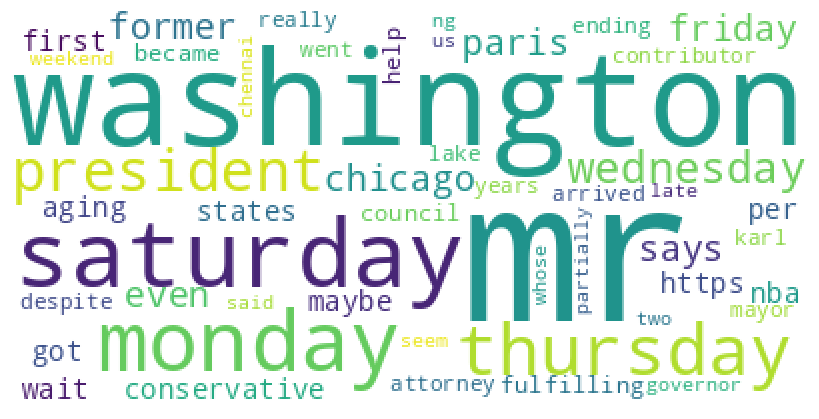

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

filtered_tokens = []

for i in range(len(combined_attr_tokens_list)):
  if not((combined_attr_tokens_list[i] == '[PAD]') or (combined_attr_tokens_list[i] == '[SEP]') or (len(combined_attr_tokens_list[i]) == 1)):
    if not(("#" in combined_attr_tokens_list[i]) and (len(combined_attr_tokens_list[i].replace("#", "")) < 2)):
      filtered_tokens.append(combined_attr_tokens_list[i])

tokens_str = " ".join(filtered_tokens)
print(len(filtered_tokens))
print(filtered_tokens)

wordcloud = WordCloud(background_color ='white',
                      min_font_size = 10).generate(tokens_str)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

In [ ]:
# TESTING (for visualization purposes)

article_num = 4180

eng_advtest_vocab_sample = X_test_tokenized["input_ids"]
print("Orig:", eng_advtest_vocab_sample[article_num])

token_sample = tokenizer.convert_ids_to_tokens(eng_advtest_vocab_sample[article_num])
print("Tokens:", token_sample)

base_sample = [tokenizer.cls_token_id] + ([tokenizer.pad_token_id]*(len(eng_advtest_vocab_sample[article_num]) - 2))  + [tokenizer.sep_token_id]
print("Baseline:", base_sample)

testing = model(torch.tensor([eng_advtest_vocab_sample[article_num]]).cuda())
# outputs logits - non-normalized probability for each class(0/true and 1/fake)
print("Logits: ", testing[0][0])

text = tokenizer.decode(eng_advtest_vocab_sample[article_num])
print(text)

sample_input_ids = torch.tensor([eng_advtest_vocab_sample[article_num]]).cuda()
sample_base_ids = torch.tensor([base_sample]).cuda()

attributions_sample, delta_sample = get_attributions(sample_input_ids, sample_base_ids)
attributions_sum_sample = summarize_attributions(attributions_sample)

score_vis = viz.VisualizationDataRecord(
                        word_attributions = attributions_sum_sample,
                        pred_prob = torch.max(model(sample_input_ids)[0][0]),
                        pred_class = torch.argmax(model(sample_input_ids)[0][0]).cpu().numpy(),
                        true_class = 1,
                        attr_class = text,
                        attr_score = attributions_sum_sample.sum(),
                        raw_input_ids = token_sample,
                        convergence_score = delta_sample)

viz.visualize_text([score_vis])

Orig: [101, 2007, 1996, 2865, 9672, 2011, 16222, 10383, 7062, 12143, 4953, 1996, 4767, 1997, 1996, 3120, 2369, 1996, 15536, 3211, 19738, 5705, 17271, 1997, 28719, 17491, 4355, 2050, 1998, 1040, 12273, 22028, 1010, 2172, 1997, 2009, 4208, 2006, 3607, 1010, 1037, 2047, 3399, 2038, 6003, 2013, 7010, 6264, 1010, 1996, 2280, 2329, 6059, 2000, 17065, 1010, 2040, 4136, 11867, 4904, 8238, 1006, 1037, 2845, 2865, 13307, 1007, 2008, 1996, 3120, 1997, 1996, 29324, 2024, 2025, 2845, 23307, 2015, 2021, 1037, 2899, 25297, 1012, 1523, 1996, 3120, 1997, 2122, 22028, 1998, 29324, 2038, 2498, 2000, 2079, 2007, 3607, 2012, 2035, 1012, 1045, 3603, 2054, 1996, 3120, 2001, 2043, 1045, 3230, 1996, 3520, 4205, 1521, 1055, 13300, 16558, 25114, 2400, 1999, 2899, 1012, 1996, 3120, 1997, 2122, 22028, 3310, 2013, 2306, 2880, 7925, 1999, 2899, 5887, 1012, 2017, 2323, 2298, 2000, 2899, 2025, 2000, 4924, 1012, 1524, 2356, 2055, 3251, 2030, 2025, 15536, 3211, 19738, 5705, 2031, 2412, 2405, 2592, 2012, 1996, 2022, 1568

In [ ]:
adv_words = "completely  Completely extremely Extremely especially Especially"

adv_inputs = tokenizer(adv_words)
adv_encoded_sequence = adv_inputs["input_ids"]
adv_tokens = tokenizer.convert_ids_to_tokens(adv_encoded_sequence)

print(adv_encoded_sequence)
print(adv_tokens)

[101, 3294, 3294, 5186, 5186, 2926, 2926, 102]
['[CLS]', 'completely', 'completely', 'extremely', 'extremely', 'especially', 'especially', '[SEP]']


In [ ]:
adv_tokens = set(adv_tokens)
print(adv_tokens)

{'[SEP]', 'extremely', 'completely', 'especially', '[CLS]'}


In [ ]:
flat_attr_scores_list = [item for sublist in attr_scores_list for item in sublist]
print(len(flat_attr_scores_list))
fig = px.box(flat_attr_scores_list)

2999296


In [ ]:
# get median attribution score of 'completely' token

comp_scores = []
pos_comp = []
neg_comp = []

for i in range(len(tokens_list)):
  for j in range(len(tokens_list[i])):
    if tokens_list[i][j] == 'completely':
      comp_scores.append(attr_scores_list[i][j])

      if attr_scores_list[i][j] >= 0:
        pos_comp.append(attr_scores_list[i][j])
      else:
        neg_comp.append(attr_scores_list[i][j])

print(len(comp_scores))
print(len(pos_comp))
print(len(neg_comp))

fig = px.box(comp_scores, points="all")
fig.show()

210
58
152


In [ ]:
# get median attribution score of 'especially' token

esp_scores = []
pos_esp = []
neg_esp = []

for i in range(len(tokens_list)):
  for j in range(len(tokens_list[i])):
    if tokens_list[i][j] == 'especially':
      esp_scores.append(attr_scores_list[i][j])

      if attr_scores_list[i][j] >= 0:
        pos_esp.append(attr_scores_list[i][j])
      else:
        neg_esp.append(attr_scores_list[i][j])

print(len(esp_scores))
print(len(pos_esp))
print(len(neg_esp))

fig = px.box(esp_scores, points="all")
fig.show()

339
203
136


In [ ]:
# get median attribution score of 'extremely' token

ext_scores = []
pos_ext = []
neg_ext = []

for i in range(len(tokens_list)):
  for j in range(len(tokens_list[i])):
    if tokens_list[i][j] == 'extremely':
      ext_scores.append(attr_scores_list[i][j])

      if attr_scores_list[i][j] >= 0:
        pos_ext.append(attr_scores_list[i][j])
      else:
        neg_ext.append(attr_scores_list[i][j])

print(len(ext_scores))
print(len(pos_ext))
print(len(neg_ext))

fig = px.box(ext_scores, points="all")
fig.show()

114
39
75


In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Box(
    x=comp_scores,
    name='completely',
))
fig.add_trace(go.Box(
    x=esp_scores,
    name='especially',
))
fig.add_trace(go.Box(
    x=ext_scores,
    name='extremely',
))

fig.add_trace(go.Box(
    x=tal_scores,
    name='tal',
))

fig.add_trace(go.Box(
    x=aga_scores,
    name='##aga',
))

fig.update_layout(
    xaxis_title='Attribution scores',
    #width=700, height=1000
)

fig.update_traces(line=dict(width=1))
fig.update_traces(marker=dict(size=3))
fig.update_layout(font_family="Serif", font=dict(size=20))

fig.show()

# Fake News Filipino Dataset

The provided dataset contains around 3000 news articles in Filipino that is perfectly split of real and fake news.

In [ ]:
df_test = pd.read_csv('test-fil.csv')

## Pre-processing

The `remove_words`  will contain the list of degree adverbs commonly used in Filipino.

In [ ]:
remove_words = ['masyado', 'medyo', 'lubos', 'bahagya', 'halos', 'lubhang', 'labis',
                'lalo', 'kaunti', 'konti', 'madalang', 'minsan', 'sobra', 'talaga',
                'nang husto', 'sobrang', 'talagang', 'lubusan', 'sadyang', 'palagi']

`df_test['adverbs']` contains the adverbs stripped from each article.

In [ ]:
pat = '|'.join([r'(?<![a-zA-Z0-9]){}(?![a-zA-Z0-9])'.format(w) for w in remove_words])

df_test['adverbs'] = df_test['article'].str.findall(pat).apply(', '.join)

We remove this adverbs and create a new column called `df_test['article_new]` which now contains the modified articles.

In [ ]:
pat = '|'.join([r'(?<![a-zA-Z0-9]){}(?![a-zA-Z0-9])'.format(w) for w in remove_words])
df_test['article_new'] = df_test['article'].str.replace(pat, ' ')

<ipython-input-9-9aec9a086b86>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_test['article_new'] = df_test['article'].str.replace(pat, ' ')


In [ ]:
df_test['article_new'] = df_test['article_new'].str.replace('  ', '')

We create a new dataframe called `df_test_adv` that consists of three columns namely: `text`, `label`, and `adverbs`.

In [ ]:
df_test_orig = df_test[['article','label']]
df_test_adv  = df_test[['article_new','label','adverbs']].rename(columns={'article_new':'article'})

`df_test_adv` is converted to a csv file and this will be used as the adversarial dataset for evaluation.

In [ ]:
df_test_adv.to_csv('/content/drive/Shared drives/Thesis/Datasets/Fake-News-Filipino/DA-test-fil-adv.csv')

In [ ]:
df_test_adv.head()

,article,label,adverbs
0,"Ang nagbabalik na si Paz-Cojuangco, na hangad ...",0,
1,Sapul sa video ang kabalastugan ng mag-asawa n...,1,talaga
2,"Totoo nga ang kasabihang ""age doesn't matter.""...",1,
3,"SA halip na suwertehin, baka malasin ang iyong...",0,
4,Para sa nobyo ang nobya. Naroon ang abay ng no...,0,lubos


## Evaluation

Load existing adversarial dataset

In [ ]:
!cp "/content/drive/Shared drives/Thesis/Datasets/Fake-News-Filipino/DA-test-fil-adv.csv" "test-fil-adv.csv"

The pretrained model was finetuned to both the original dataset and the modified dataset. The pretrained model, *bert-tagalog-base-cased,* was trained using the WikiText-TL-39 dataset which is a corpus of 172,815 articles in Tagalog.

In [ ]:
pretrained = 'jcblaise/bert-tagalog-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(pretrained)
model = AutoModelForSequenceClassification.from_pretrained(pretrained)

Some weights of the model checkpoint at jcblaise/bert-tagalog-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the mo

Load finetuned models if needed

In [ ]:
!cp -r "/content/drive/Shared drives/Thesis/Models/uncased-output-fil" "output-fil"

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

Define a new dataset `analysis_data` which will be used to analyze the results.

In [ ]:
analysis_data = pd.read_csv('test-fil-adv.csv')

### Model Performance (Original)

Use the best model, step = 500.

In [ ]:
test_data = pd.read_csv("test-fil.csv")

X_test = list(test_data["article"])
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)
y_test = list(test_data["label"])

test_dataset = Dataset(X_test_tokenized)

model_path = "output-fil/checkpoint-500"
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=2)

test_trainer = Trainer(model)

raw_pred, _, _ = test_trainer.predict(test_dataset)
y_pred_orig = np.argmax(raw_pred, axis=1)

In [ ]:
original_predictions = test_trainer.predict(test_dataset).predictions

In [ ]:
accuracy = accuracy_score(y_test, y_pred_orig)
recall = recall_score(y_test, y_pred_orig)
precision = precision_score(y_test, y_pred_orig)
f1 = f1_score(y_test, y_pred_orig)

print("ORIGINAL TEST DATASET (FILIPINO):")
print("Accuracy: {}".format(accuracy))
print("Recall: {}".format(recall))
print("Precision: {}".format(precision))
print("F1-score: {}".format(f1))

cm = confusion_matrix(y_test, y_pred_orig)

fig = px.imshow(cm, text_auto=True, title='Confusion Matrix of original test data (Filipino Fake News)', color_continuous_scale='haline')
fig.update_xaxes(dtick=1)
fig.update_yaxes(dtick=1)
fig.show()

ORIGINAL TEST DATASET (FILIPINO):
Accuracy: 0.9324324324324325
Recall: 0.9417879417879418
Precision: 0.9244897959183673
F1-score: 0.933058702368692


In [ ]:
analysis_data['unprocessed'] = list(test_data["article"])
analysis_data['orig_pred'] = y_pred_orig

### Model Performance (Adversarial)

In [ ]:
test_data = pd.read_csv("test-fil-adv.csv")
X_test = list(test_data["article"])
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)
y_test = list(test_data["label"])

test_dataset = Dataset(X_test_tokenized)

model_path = "output-fil/checkpoint-500"
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=2)

test_trainer = Trainer(model)

raw_pred, _, _ = test_trainer.predict(test_dataset)

y_pred = np.argmax(raw_pred, axis=1)

In [ ]:
adversarial_predictions = test_trainer.predict(test_dataset).predictions

In [ ]:
analysis_data['adv_pred'] = y_pred

In [ ]:
analysis_data['processed'] = list(test_data["article"])

### Average Probability Change

In [ ]:
original_probs = softmax(original_predictions, axis=1)
adversarial_probs = softmax(adversarial_predictions, axis=1)
delta_lst = adversarial_probs[:, 1] - original_probs[:, 1]
average_prob_change = round(float(np.mean(delta_lst)), 4)

print(f"Average Probability Change: {average_prob_change}")

Average Probability Change: 0.0004


### %LabelFlip

In [ ]:
cm = confusion_matrix(y_test, y_pred_orig)

misclassification_rate = np.sum(y_pred_orig != y_pred)
percentage = round(100 * (misclassification_rate / np.sum(cm)), 4)

print(f"%LabelFlip: {misclassification_rate}/{np.sum(cm)} ({percentage}%)")

%LabelFlip: 1/962 (0.104%)


In [ ]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("ADVERSARIAL TEST DATASET (FILIPINO):")
print("Accuracy: {}".format(accuracy))
print("Recall: {}".format(recall))
print("Precision: {}".format(precision))
print("F1-score: {}".format(f1))

cm = confusion_matrix(y_test, y_pred)

fig = px.imshow(cm, text_auto=True, title='Confusion Matrix of adversarial test data (Filipino Fake News)', color_continuous_scale='haline')
fig.update_xaxes(dtick=1)
fig.update_yaxes(dtick=1)
fig.update_layout(font_family="Serif", font=dict(size=20))
fig.show()

ADVERSARIAL TEST DATASET (FILIPINO):
Accuracy: 0.9313929313929314
Recall: 0.9417879417879418
Precision: 0.9226069246435845
F1-score: 0.9320987654320987


## Analysis

In [ ]:
analysis_data['num_removed']  = analysis_data['adverbs'].str.split().str.len()
analysis_data['adverbs']= analysis_data['adverbs'].fillna('None')
analysis_data['num_removed']= analysis_data['num_removed'].fillna(0)
analysis_data['num_removed']= analysis_data['num_removed'].astype(int)

In [ ]:
analysis_data.head()

,Unnamed: 0,article,label,adverbs,unprocessed,orig_pred,adv_pred,processed,num,num_removed
0,0,"Ang nagbabalik na si Paz-Cojuangco, na hangad ...",0,None,"Ang nagbabalik na si Paz-Cojuangco, na hangad ...",0,0,"Ang nagbabalik na si Paz-Cojuangco, na hangad ...",0.0,1
1,1,Sapul sa video ang kabalastugan ng mag-asawa n...,1,talaga,Sapul sa video ang kabalastugan ng mag-asawa n...,1,1,Sapul sa video ang kabalastugan ng mag-asawa n...,1.0,1
2,2,"Totoo nga ang kasabihang ""age doesn't matter.""...",1,None,"Totoo nga ang kasabihang ""age doesn't matter.""...",1,1,"Totoo nga ang kasabihang ""age doesn't matter.""...",0.0,1
3,3,"SA halip na suwertehin, baka malasin ang iyong...",0,None,"SA halip na suwertehin, baka malasin ang iyong...",0,0,"SA halip na suwertehin, baka malasin ang iyong...",0.0,1
4,4,Para sa nobyo ang nobya. Naroon ang abay ng no...,0,lubos,Para sa nobyo ang nobya. Naroon ang abay ng no...,0,0,Para sa nobyo ang nobya. Naroon ang abay ng no...,1.0,1


In [ ]:
analysis_data.to_csv('/content/drive/Shared drives/Thesis/Datasets/Fake-News-Filipino/Analysis/fil-adverbs-analysis.csv', index=False)

If needed, load `eng-adverbs-analysis.csv` dataset for analysis.

In [ ]:
!cp "/content/drive/Shared drives/Thesis/Datasets/Fake-News-Filipino/Analysis/fil-adverbs-analysis.csv" "fil-adverbs-analysis.csv"

Create a 2D list called `remove_words_count` that contains the adverbs that were removed with its corresponding count of contributions to label flips.

In [ ]:
remove_words = ['masyado', 'medyo', 'lubos', 'bahagya', 'halos', 'lubhang', 'labis',
                'lalo', 'kaunti', 'konti', 'madalang', 'minsan', 'sobra', 'talaga',
                'nang husto', 'sobrang', 'talagang', 'lubusan', 'sadyang', 'palagi']

In [ ]:
analysis_data = pd.read_csv("fil-adverbs-analysis.csv")
analysis_data = analysis_data.reset_index()
analysis_data.head()

,index,Unnamed: 0,article,label,adverbs,unprocessed,orig_pred,adv_pred,processed,num,num_removed
0,0,0,"Ang nagbabalik na si Paz-Cojuangco, na hangad ...",0,None,"Ang nagbabalik na si Paz-Cojuangco, na hangad ...",0,0,"Ang nagbabalik na si Paz-Cojuangco, na hangad ...",0.0,1
1,1,1,Sapul sa video ang kabalastugan ng mag-asawa n...,1,talaga,Sapul sa video ang kabalastugan ng mag-asawa n...,1,1,Sapul sa video ang kabalastugan ng mag-asawa n...,1.0,1
2,2,2,"Totoo nga ang kasabihang ""age doesn't matter.""...",1,None,"Totoo nga ang kasabihang ""age doesn't matter.""...",1,1,"Totoo nga ang kasabihang ""age doesn't matter.""...",0.0,1
3,3,3,"SA halip na suwertehin, baka malasin ang iyong...",0,None,"SA halip na suwertehin, baka malasin ang iyong...",0,0,"SA halip na suwertehin, baka malasin ang iyong...",0.0,1
4,4,4,Para sa nobyo ang nobya. Naroon ang abay ng no...,0,lubos,Para sa nobyo ang nobya. Naroon ang abay ng no...,0,0,Para sa nobyo ang nobya. Naroon ang abay ng no...,1.0,1


In [ ]:
average_num_removed = analysis_data['num_removed'].mean()
num_rows_with_zero = (analysis_data['num_removed'] == 0).sum()

print("Average adverbs removed:", average_num_removed)
print("Number of records with no adverbs removed:", num_rows_with_zero)

Average adverbs removed: 1.1278586278586278
Number of records with no adverbs removed: 0


In [ ]:
adverb_counts = {}

for index, row in analysis_data.iterrows():
    adverbs = row['adverbs']
    label = row['label']
    if adverbs is not None:
        adverbs = [adverb.strip() for adverb in adverbs.split(',') if adverb.strip()]
        for adverb in adverbs:
            adverb = adverb.lower()
            if adverb == 'none':
                continue
            if label in adverb_counts:
                adverb_counts[label][adverb] = adverb_counts[label].get(adverb, 0) + 1
            else:
                adverb_counts[label] = {adverb: 1}

adverb_dfs = []

for label, counts in adverb_counts.items():
    adverb_df = pd.DataFrame(counts.items(), columns=['Adverb', 'Count'])
    adverb_df = adverb_df.sort_values('Count', ascending=False).reset_index(drop=True)
    adverb_df['Label'] = label
    adverb_dfs.append(adverb_df)

adverb_combined_df = pd.concat(adverb_dfs, ignore_index=True)

print(adverb_combined_df)

        Adverb  Count  Label
0       talaga     90      1
1        labis     34      1
2         lalo     31      1
3     talagang     26      1
4        halos     26      1
5      sobrang     10      1
6       minsan     10      1
7        medyo      6      1
8      masyado      5      1
9        sobra      4      1
10      kaunti      4      1
11     lubusan      3      1
12       lubos      2      1
13       konti      1      1
14      palagi      1      1
15     sadyang      1      1
16      talaga     24      0
17        lalo     20      0
18       halos     14      0
19       medyo      7      0
20    talagang      5      0
21       labis      5      0
22  nang husto      4      0
23     sobrang      4      0
24      minsan      3      0
25       lubos      2      0
26       sobra      2      0
27      kaunti      1      0


### Adverbs Count

In [ ]:
adverb_combined_df['Label'] = adverb_combined_df['Label'].astype(str)

In [ ]:
fig = px.bar(adverb_combined_df, y='Adverb', x='Count', color="Label",
             title='Adverb Occurence according to Label',
             orientation = "h",
             height = 750,
             color_discrete_sequence=px.colors.qualitative.Pastel)
fig.update_layout(font_family="Serif", font=dict(size=20))
fig.show()

### Contributions to Label Flip

In [ ]:
#filter by getting only those that flipped the label
filtered_data = analysis_data[analysis_data['adv_pred'] != analysis_data['orig_pred']]

#true if match (improved the model), false if mismatch (adversarial)
filtered_data['label_match'] = filtered_data['adv_pred'] == filtered_data['label']

filtered_data['label_match'].head()

<ipython-input-86-5436ba889792>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



245    False
Name: label_match, dtype: bool

In [ ]:
print(filtered_data.loc[245])

index                                                        245
Unnamed: 0                                                   245
article        "Saka bukod sa ipinagdarasal ko ngayon, siyemp...
label                                                          0
adverbs                                                   talaga
unprocessed    "Saka bukod sa ipinagdarasal ko ngayon, siyemp...
orig_pred                                                      0
adv_pred                                                       1
processed      "Saka bukod sa ipinagdarasal ko ngayon, siyemp...
num                                                          1.0
label_match                                                False
Name: 245, dtype: object


In [ ]:
#group by label_match
grouped_data = filtered_data.groupby(['label', 'label_match']).size().reset_index(name='count')

In [ ]:
fig = px.bar(grouped_data, x='label', y='count', color='label_match',
             labels={'label': 'Label', 'count': 'Count', 'label_match': 'Correct?'},
             title='Label Flip Contributions',
             color_discrete_sequence=px.colors.qualitative.Pastel,
             text='count',
             hover_data={'count': True})

fig.show()

## Interpreting BERT-Tagalog output using Integrated Gradients

In [ ]:
model_input = model.bert.embeddings

def model_output(inputs):
  return model(inputs)[0][0]

lig = LayerIntegratedGradients(model_output, model_input)
print(lig)

In [ ]:
adv_articles = pd.read_csv('test-fil.csv').copy(deep=True)

In [ ]:
adv_articles = adv_articles[['article']].copy(deep=True)

In [ ]:
print(adv_articles)

                                               article
0    Ang nagbabalik na si Paz-Cojuangco, na hangad ...
1    Sapul sa video ang kabalastugan ng mag-asawa n...
2    Totoo nga ang kasabihang "age doesn't matter."...
3    SA halip na suwertehin, baka malasin ang iyong...
4    Para sa nobyo ang nobya. Naroon ang abay ng no...
..                                                 ...
957  Ang 14-time Grand Slam winner ay nagkaroon ng ...
958  Ang resignation ni Darren Wilson ay kaagad na ...
959  Ayon kay committee chairman Senator Teofisto G...
960  Usap-usapan ngayon sa social media ang umano'y...
961  Tuwing panahon ng halalan, hindi magkandaugaga...

[962 rows x 1 columns]


In [ ]:
adv_articles_index = list(adv_articles.index.values)
adv_articles = adv_articles.values.tolist()

orig_input_ids_list = []
base_input_ids_list = []
tokens_list = []

# copy token IDs of adversarial articles
adv_input_ids = X_test_tokenized["input_ids"]
for i in range(len(adv_articles_index)):
  orig_input_ids_list.append(adv_input_ids[i])

# get baseline token IDs and list of tokens of each adversarial article
for i in range(len(orig_input_ids_list)):
  baseline_ids = [tokenizer.cls_token_id] + ([tokenizer.pad_token_id]*(len(orig_input_ids_list[i]) - 2))  + [tokenizer.sep_token_id]
  tokens = tokenizer.convert_ids_to_tokens(orig_input_ids_list[i])

  base_input_ids_list.append(baseline_ids)
  tokens_list.append(tokens)

print(len(orig_input_ids_list))
print(len(adv_articles))
print(len(base_input_ids_list))
print(len(tokens_list))

962
962
962
962


In [ ]:
# TESTING

fil_advtest_vocab = X_test_tokenized["input_ids"]
print("Orig:", fil_advtest_vocab[0])

token_test = tokenizer.convert_ids_to_tokens(fil_advtest_vocab[0])
print("Tokens:", token_test)

base_test = [tokenizer.cls_token_id] + ([tokenizer.pad_token_id]*(len(fil_advtest_vocab[0]) - 2))  + [tokenizer.sep_token_id]
print("Baseline:", base_test)

testing = model(torch.tensor([fil_advtest_vocab[0]]).cuda())
# outputs logits - non-normalized probability for each class(0/true and 1/fake)
print("Logits: ", testing[0][0])

text = tokenizer.decode(fil_advtest_vocab[0])
print(text)

Orig: [101, 105, 14430, 14589, 106, 126, 422, 4698, 30031, 803, 16953, 123, 1951, 30026, 106, 20236, 105, 1113, 1309, 123, 4193, 28340, 11179, 541, 4571, 107, 619, 11828, 106, 351, 11600, 2749, 3926, 592, 398, 2229, 984, 19771, 2140, 30026, 118, 14430, 15300, 104, 11271, 1220, 1220, 123, 12818, 989, 10169, 28322, 107, 9998, 129, 1774, 292, 863, 2252, 14962, 18408, 10645, 30037, 8926, 630, 113, 8926, 586, 30038, 106, 261, 9753, 145, 7445, 107, 15736, 1510, 962, 104, 22631, 3193, 4895, 106, 126, 3462, 3235, 3457, 3252, 696, 104, 246, 296, 30025, 432, 910, 519, 30026, 26931, 268, 104, 11678, 984, 123, 643, 1451, 107, 2676, 1220, 145, 207, 2060, 28340, 7735, 30073, 113, 10413, 5685, 30066, 30011, 118, 375, 9976, 2586, 398, 2060, 422, 4698, 30031, 803, 16953, 123, 1951, 105, 340, 22631, 26852, 159, 30025, 23249, 133, 2377, 7445, 104, 185, 8169, 729, 14430, 5091, 594, 296, 4969, 729, 1589, 145, 11179, 7992, 133, 105, 3563, 111, 30015, 268, 372, 1451, 9533, 107, 340, 22631, 26852, 159, 107, 4

In [ ]:
from IPython.display import HTML, display
import time

def progress(value, max):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

def get_attributions(input_ids, base_ids):
  attributions, delta = lig.attribute(inputs= input_ids,
                                      baselines= base_ids,
                                      return_convergence_delta=True,
                                      internal_batch_size=1
                                      )

  return attributions, delta

def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)

    return attributions

In [ ]:
# DO NOT RUN IF .npy FILE ALREADY EXISTS
# list of attribution scores of each article
attr_scores_list = []

out = display(progress(0, 512), display_id=True)
for i in range(len(orig_input_ids_list)):
  input_ids = torch.tensor([orig_input_ids_list[i]]).cuda()
  base_ids = torch.tensor([base_input_ids_list[i]]).cuda()

  attributions, delta = get_attributions(input_ids, base_ids)
  attributions_sum = summarize_attributions(attributions)

  attr_scores_list.append(attributions_sum)
  out.update(progress(i, 512))

print(len(attributions_sum))

512


In [ ]:
# Save list of attribution scores in a file for future use (SKIP IF .npy FILE ALREADY EXISTS)

attr_scores_file = []

for arr in attr_scores_list:
  new = arr.cpu().detach().numpy()
  attr_scores_file.append(new)

np.save('uncased_adverb_fil_attr_scores.npy', np.array(attr_scores_file))

!cp -r "uncased_adverb_fil_attr_scores.npy" "/content/drive/Shared drives/Thesis/Attribution Scores"

In [ ]:
# Copy .npy file to local storage
!cp "/content/drive/Shared drives/Thesis/Attribution Scores/uncased_adverb_fil_attr_scores.npy" "uncased_adverb_fil_attr_scores.npy"

In [ ]:
# Load .npy file
attr_scores_list = np.load('uncased_adverb_fil_attr_scores.npy')
attr_scores_list = list(attr_scores_list)

print(type(attr_scores_list))     # type -> list
print(type(attr_scores_list[0]))  # type -> numpy.ndarray

<class 'list'>
<class 'numpy.ndarray'>


In [ ]:
print("Input IDS: ", orig_input_ids_list[0])
print("Baseline IDS: ",base_input_ids_list[0])
print("Tokens: ",tokens_list[0])
print("Text: ",adv_articles[0])
print("Attr.: ", attr_scores_list[0])

Input IDS:  [101, 105, 14430, 14589, 106, 126, 422, 4698, 30031, 803, 16953, 123, 1951, 30026, 106, 20236, 105, 1113, 1309, 123, 4193, 28340, 11179, 541, 4571, 107, 619, 11828, 106, 351, 11600, 2749, 3926, 592, 398, 2229, 984, 19771, 2140, 30026, 118, 14430, 15300, 104, 11271, 1220, 1220, 123, 12818, 989, 10169, 28322, 107, 9998, 129, 1774, 292, 863, 2252, 14962, 18408, 10645, 30037, 8926, 630, 113, 8926, 586, 30038, 106, 261, 9753, 145, 7445, 107, 15736, 1510, 962, 104, 22631, 3193, 4895, 106, 126, 3462, 3235, 3457, 3252, 696, 104, 246, 296, 30025, 432, 910, 519, 30026, 26931, 268, 104, 11678, 984, 123, 643, 1451, 107, 2676, 1220, 145, 207, 2060, 28340, 7735, 30073, 113, 10413, 5685, 30066, 30011, 118, 375, 9976, 2586, 398, 2060, 422, 4698, 30031, 803, 16953, 123, 1951, 105, 340, 22631, 26852, 159, 30025, 23249, 133, 2377, 7445, 104, 185, 8169, 729, 14430, 5091, 594, 296, 4969, 729, 1589, 145, 11179, 7992, 133, 105, 3563, 111, 30015, 268, 372, 1451, 9533, 107, 340, 22631, 26852, 159, 

In [ ]:
# TEST - get indices of scores >= 0 (positive values)

attr_ind_list = []

for i in range(len(attr_scores_list)):
  attr_ind = []

  for j in range(len(attr_scores_list[i])):
    if attr_scores_list[i][j] >= 0.5:
      attr_ind.append(j)

  attr_ind_list.append(attr_ind)

print(attr_ind_list)

[[], [143], [], [], [1], [440], [172], [], [], [], [], [], [457], [], [], [480], [1], [], [1], [], [], [], [1], [], [], [1], [], [1], [143], [], [1], [191, 411], [], [1], [], [], [], [], [], [175], [], [], [], [], [1], [], [1], [1], [1], [136], [], [], [1], [], [1], [1], [], [], [], [1, 116], [163], [], [1], [], [427], [], [450], [], [1], [], [], [], [135], [], [], [1], [1], [1], [], [1], [1], [], [], [], [], [1], [], [1], [], [], [1], [27], [1], [], [1, 135], [], [], [], [], [], [], [], [], [], [], [174], [1], [], [], [], [1], [], [], [70], [], [], [], [], [], [1], [1], [], [], [1], [], [174], [], [1], [1], [], [1], [], [], [], [1], [], [1], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [1], [], [], [435], [], [], [], [1], [], [], [], [162], [1], [1], [], [1], [], [], [], [], [1], [], [], [1], [], [], [], [], [1], [], [], [], [], [1], [1], [], [], [1], [], [1], [], [], [], [1], [1], [1], [], [462], [1], [1], [], [1], [], [], [], [], [466], [1], [], [], [], [1], [193]

In [ ]:
# check corresponding tokens

attr_tokens_list = []

for i in range(len(attr_ind_list)):
  attr_tokens = []

  for j in range(len(attr_ind_list[i])):
    attr_tokens.append(tokens_list[i][attr_ind_list[i][j]])

  attr_tokens_list.append(attr_tokens)

print(attr_tokens_list)

[[], ['##a'], [], [], ['par'], [':'], ['[SEP]'], [], [], [], [], [], [':'], [], [], ['##w'], ['sina'], [], ['kin'], [], [], [], ['ang'], [], [], ['maka'], [], ['sina'], ['##at'], [], ['pat'], ['ild', '##have'], [], ['pali'], [], [], [], [], [], ['[SEP]'], [], [], [], [], ['san'], [], ['ayon'], ['ito'], ['ayon'], ['##g'], [], [], ['sak'], [], ['kas'], ['uma'], [], [], [], ['may', '[SEP]'], ['[SEP]'], [], ['ayon'], [], [':'], [], ['[PAD]'], [], ['"'], [], [], [], ['.'], [], [], ['ilan'], ['a'], ['ma'], [], ['hin'], ['nak'], [], [], [], [], ['ito'], [], ['tina'], [], [], ['nila'], ['##guard'], ['nag'], [], ['"', '##s'], [], [], [], [], [], [], [], [], [], [], ['##a'], ['masa'], [], [], [], ['unang'], [], [], ['[SEP]'], [], [], [], [], [], ['hin'], ['re'], [], [], ['ayon'], [], ['##en'], [], ['sina'], ['ped'], [], ['sama'], [], [], [], ['nak'], [], ['band'], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], ['ito'], [], [], ['-'], [], [], [], ['"'], [], [], [], ['[SEP]'], ['u

In [ ]:
combined_attr_tokens_list = [x for attr_tokens in attr_tokens_list for x in attr_tokens]
# combined_attr_tokens_list = set(combined_attr_tokens_list)
# combined_attr_tokens_list

In [ ]:
%%capture
!pip install matplotlib
!pip install wordcloud

243
['par', 'sina', 'kin', 'ang', 'maka', 'sina', '##at', 'pat', 'ild', '##have', 'pali', 'san', 'ayon', 'ito', 'ayon', 'sak', 'kas', 'uma', 'may', 'ayon', 'ilan', 'ma', 'hin', 'nak', 'ito', 'tina', 'nila', '##guard', 'nag', 'masa', 'unang', 'hin', 're', 'ayon', '##en', 'sina', 'ped', 'sama', 'nak', 'band', 'ito', 'uma', 'mata', 'mu', 'ka', 'isa', 'pina', 'isina', 'ma', 'ang', 'mala', 'ito', 'ini', 'ina', 'tina', 'da', 'hin', 'nila', 'ipin', 'kin', 'ku', 'banta', 'ayon', 'mag', 'ito', 'papa', 'kas', 'kin', 'hin', 'sina', 'tu', 'ori', 'kap', 'unang', 'ayon', 'cle', 'ayon', 'sum', 'not', 'sina', 'hu', 'nak', 'nak', 'ang', 'nag', 'ito', 'nakulo', 'ayon', 'rew', 'ayon', 'tat', 'ayon', 'pat', 'ina', 'halo', 'una', 'nak', 'si', 'kin', 'ini', 'ayon', 'mata', 'nak', 'nak', 'ku', 'ayon', 'ayon', 'batay', 'kab', 'hin', '##vo', 'ito', 'baga', 'ang', 'tu', 'ito', '##di', '##each', 'na', 'ku', 'nang', 'kar', 'mi', 'sina', 'ani', 'hin', 'nana', 'ito', 'sina', 'inam', 'cle', 'ni', 'lupa', 'patuloy', 

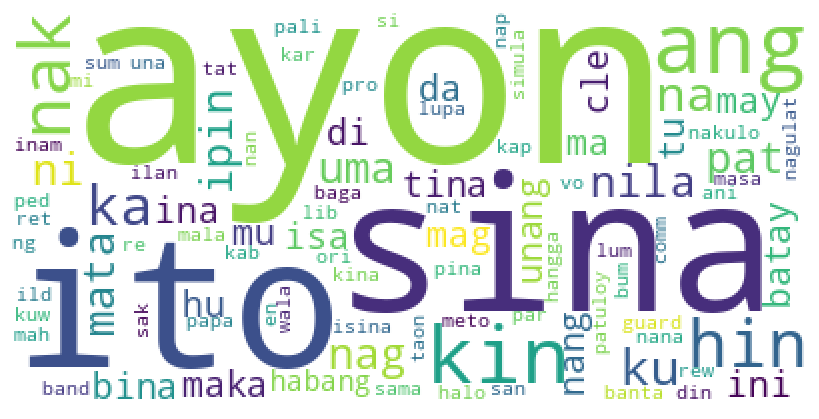

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

filtered_tokens = []

for i in range(len(combined_attr_tokens_list)):
  if not((combined_attr_tokens_list[i] == '[PAD]') or (combined_attr_tokens_list[i] == '[SEP]') or (len(combined_attr_tokens_list[i]) == 1)):
    if not(("#" in combined_attr_tokens_list[i]) and (len(combined_attr_tokens_list[i].replace("#", "")) < 2)):
      filtered_tokens.append(combined_attr_tokens_list[i])

tokens_str = " ".join(filtered_tokens)
print(len(filtered_tokens))
print(filtered_tokens)

wordcloud = WordCloud(background_color ='white',
                      min_font_size = 10).generate(tokens_str)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

In [ ]:
set_combined_attr_tokens_list = list(set(combined_attr_tokens_list))

for i in set_combined_attr_tokens_list:
  print(i, " occurence: ", combined_attr_tokens_list.count(i))

taon  occurence:  1
kin  occurence:  11
##di  occurence:  2
hangga  occurence:  1
ito  occurence:  15
pali  occurence:  1
:  occurence:  25
ni  occurence:  3
kina  occurence:  1
lum  occurence:  1
sum  occurence:  1
ilan  occurence:  1
nak  occurence:  8
##g  occurence:  4
nag  occurence:  3
##5  occurence:  1
din  occurence:  1
##en  occurence:  1
emo  occurence:  1
tat  occurence:  1
mala  occurence:  1
ma  occurence:  2
bu  occurence:  1
##w  occurence:  3
re  occurence:  1
ini  occurence:  2
not  occurence:  1
##at  occurence:  2
nana  occurence:  1
nap  occurence:  1
habang  occurence:  2
sak  occurence:  1
no  occurence:  1
pro  occurence:  1
may  occurence:  2
nakulo  occurence:  1
nila  occurence:  3
si  occurence:  1
##me  occurence:  1
bum  occurence:  1
mu  occurence:  2
a  occurence:  1
##ng  occurence:  1
##s  occurence:  4
ang  occurence:  13
inam  occurence:  1
e  occurence:  1
cle  occurence:  2
tu  occurence:  2
lib  occurence:  1
hu  occurence:  2
##yang  occurence:  

In [ ]:
# TESTING (for visualization purposes)

article_num = 121

fil_advtest_vocab_sample = X_test_tokenized["input_ids"]
print("Orig:", fil_advtest_vocab_sample[article_num])

token_sample = tokenizer.convert_ids_to_tokens(fil_advtest_vocab_sample[article_num])
print("Tokens:", token_sample)

base_sample = [tokenizer.cls_token_id] + ([tokenizer.pad_token_id]*(len(fil_advtest_vocab_sample[article_num]) - 2))  + [tokenizer.sep_token_id]
print("Baseline:", base_sample)

testing = model(torch.tensor([fil_advtest_vocab_sample[article_num]]).cuda())
# outputs logits - non-normalized probability for each class(0/true and 1/fake)
print("Logits: ", testing[0][0])

text = tokenizer.decode(fil_advtest_vocab_sample[article_num])
print(text)

sample_input_ids = torch.tensor([fil_advtest_vocab_sample[article_num]]).cuda()
sample_base_ids = torch.tensor([base_sample]).cuda()

attributions_sample, delta_sample = get_attributions(sample_input_ids, sample_base_ids)
attributions_sum_sample = summarize_attributions(attributions_sample)

score_vis = viz.VisualizationDataRecord(
                        word_attributions = attributions_sum_sample,
                        pred_prob = torch.max(model(sample_input_ids)[0][0]),
                        pred_class = torch.argmax(model(sample_input_ids)[0][0]).cpu().numpy(),
                        true_class = 1,
                        attr_class = text,
                        attr_score = attributions_sum_sample.sum(),
                        raw_input_ids = token_sample,
                        convergence_score = delta_sample)

viz.visualize_text([score_vis])

Orig: [101, 107, 23895, 104, 24899, 541, 30026, 6114, 111, 12268, 13742, 159, 107, 3479, 775, 2437, 120, 105, 15260, 30026, 118, 9919, 3062, 2233, 6480, 25348, 14584, 140, 106, 115, 3492, 104, 3479, 2586, 2486, 123, 413, 966, 104, 24899, 541, 113, 104, 3479, 2586, 2486, 398, 413, 684, 104, 3887, 12065, 30025, 674, 5918, 13820, 105, 276, 28159, 6471, 296, 24899, 541, 635, 6498, 14001, 29472, 17364, 4300, 6471, 120, 2326, 7716, 179, 30026, 9011, 635, 6498, 14001, 18904, 4616, 159, 23031, 159, 656, 305, 10273, 398, 30075, 275, 30025, 30026, 3887, 12065, 27664, 9919, 527, 18770, 2326, 7716, 179, 6638, 120, 113, 104, 30015, 268, 2538, 21794, 109, 8097, 104, 25588, 413, 966, 30025, 115, 3492, 254, 107, 107, 2825, 104, 24899, 541, 21364, 12028, 140, 11204, 541, 1121, 14475, 243, 107, 3887, 12065, 106, 107, 18521, 2060, 1400, 118, 1472, 13557, 140, 105, 28672, 159, 219, 2060, 26713, 30025, 3062, 1499, 24899, 541, 30025, 107, 21234, 14307, 30026, 24899, 541, 30026, 105, 276, 28159, 118, 674, 59

In [ ]:
adverbs = "talaga Talaga"
#adverbs_other = "medyo Medyo lubos Lubos bahagya Bahagya halos Halos lubhang Lubhang labis Labis lalo Lalo kaunti Kaunti konti Konti madalang Madalang minsan Minsan sobra Sobra talaga Talaga nang Nang husto Husto sobrang Sobrang talagang Talagang lubusan Lubusan sadyang Sadyang palagi Palagi"

adverb_inputs = tokenizer(adverbs)
adverb_encoded_sequence = adverb_inputs["input_ids"]
adverb_tokens = tokenizer.convert_ids_to_tokens(adverb_encoded_sequence)

print(adverb_encoded_sequence)
print(adverb_tokens)

[101, 6958, 6099, 6958, 6099, 102]
['[CLS]', 'tal', '##aga', 'tal', '##aga', '[SEP]']


In [ ]:
adverb_tokens = set(adverb_tokens)
adverb_tokens.remove('[CLS]')
adverb_tokens.remove('[SEP]')
print(adverb_tokens)

{'tal', '##aga'}


In [ ]:
flat_attr_scores_list = [item for sublist in attr_scores_list for item in sublist]
print(len(flat_attr_scores_list))
fig = px.box(flat_attr_scores_list)
fig.show()

Output hidden; open in https://colab.research.google.com to view.

`tal` from `talaga`

In [ ]:
# get median attribution score of 'tal' token

tal_scores = []
pos_tal = []
neg_tal = []

for i in range(len(tokens_list)):
  for j in range(len(tokens_list[i])):
    if tokens_list[i][j] == 'tal':
      tal_scores.append(attr_scores_list[i][j])

      if attr_scores_list[i][j] >= 0:
        pos_tal.append(attr_scores_list[i][j])
      else:
        neg_tal.append(attr_scores_list[i][j])

print(len(tal_scores))
print(len(pos_tal))
print(len(neg_tal))

fig = px.box(tal_scores, points="all")
fig.show()

110
67
43


`##aga` from `talaga`

In [ ]:
# get median attribution score of '##aga' token

aga_scores = []
pos_aga = []
neg_aga = []

for i in range(len(tokens_list)):
  for j in range(len(tokens_list[i])):
    if tokens_list[i][j] == 'aga':
      aga_scores.append(attr_scores_list[i][j])

      if attr_scores_list[i][j] >= 0:
        pos_aga.append(attr_scores_list[i][j])
      else:
        neg_aga.append(attr_scores_list[i][j])

print(len(aga_scores))
print(len(pos_aga))
print(len(neg_aga))

fig = px.box(aga_scores, points="all")
fig.show()

46
28
18


# Attributions


1.   [An Adversarial Benchmark for Fake News Detection Models](https://github.com/ljyflores/fake-news-adversarial-benchmark/blob/master/polarity_preprocessing.ipynb)
2.   [Fine-tuning pretrained NLP models with Huggingface’s Trainer](https://towardsdatascience.com/fine-tuning-pretrained-nlp-models-with-huggingfaces-trainer-6326a4456e7b)